# 深度学习100例-卷积神经网络（CNN）识别验证码 | 第12天

## 1.前期工作

### 1.1 导入数据

In [28]:
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

import os,PIL,random,pathlib

# 设置随机种子尽可能使结果可以重现
import numpy as np
np.random.seed(1)

# 设置随机种子尽可能使结果可以重现
import tensorflow as tf
tf.random.set_seed(1)

《深度学习100例》第12天的数据链接如下

https://pan.baidu.com/s/1seo9uOykQwAcsV7_Wqw7gQ（提取码：vw70）

In [29]:
data_dir = "F:/DeepLearning/day-12/captcha/"
data_dir = pathlib.Path(data_dir)

all_image_paths = list(data_dir.glob('*'))
all_image_paths = [str(path) for path in all_image_paths]

# 打乱数据
random.shuffle(all_image_paths)

# 获取数据标签
all_label_names = [path.split("\\")[-1].split(".")[0] for path in all_image_paths]

image_count = len(all_image_paths)
print("图片总数为：",image_count)

图片总数为： 1070


### 1.2.数据可视化

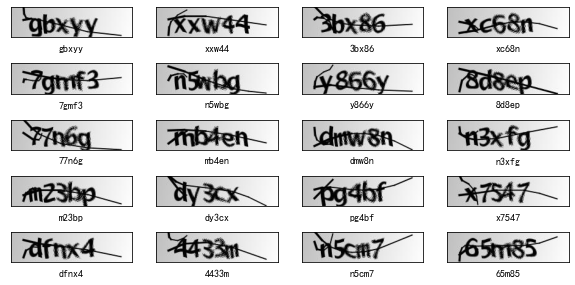

In [30]:
plt.figure(figsize=(10,5))

for i in range(20):
    plt.subplot(5,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    # 显示图片
    images = plt.imread(all_image_paths[i])
    plt.imshow(images)
    # 显示标签
    plt.xlabel(all_label_names[i])

plt.show()

### 1.3 标签数字化

In [31]:
number   = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
char_set       = number + alphabet
char_set_len   = len(char_set)
label_name_len = len(all_label_names[0])


# 将字符串数字化
def text2vec(text):
    vector = np.zeros([label_name_len, char_set_len])
    for i, c in enumerate(text):
        idx = char_set.index(c)
        vector[i][idx] = 1.0
    return vector

all_labels = [text2vec(i) for i in all_label_names]

## 2.构建一个tf.data.Dataset

### 2.1预处理函数

In [32]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [50, 200])
    return image/255.0

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

### 2.2 加载数据

构建 `tf.data.Dataset` 最简单的方法就是使用 `from_tensor_slices` 方法。

In [33]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

path_ds  = tf.data.Dataset.from_tensor_slices(all_image_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(all_labels)

image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
image_label_ds

<ZipDataset element_spec=(TensorSpec(shape=(50, 200, 1), dtype=tf.float32, name=None), TensorSpec(shape=(5, 36), dtype=tf.float64, name=None))>

In [34]:
train_ds = image_label_ds.take(1000)  # 前1000个batch
val_ds   = image_label_ds.skip(1000)  # 跳过前1000，选取后面的

### 2.3配置数据

先复习一下`prefetch()`函数。`prefetch()`功能详细介绍：CPU 正在准备数据时，加速器处于空闲状态。相反，当加速器正在训练模型时，CPU 处于空闲状态。因此，训练所用的时间是 CPU 预处理时间和加速器训练时间的总和。`prefetch()`将训练步骤的预处理和模型执行过程重叠到一起。当加速器正在执行第 N 个训练步时，CPU 正在准备第 N+1 步的数据。这样做不仅可以最大限度地缩短训练的单步用时（而不是总用时），而且可以缩短提取和转换数据所需的时间。如果不使用`prefetch()`，CPU 和 GPU/TPU 在大部分时间都处于空闲状态：

![](https://img-blog.csdnimg.cn/20210623143718552.png#pic_center)
    
使用`prefetch()`可显著减少空闲时间：  
![](https://img-blog.csdnimg.cn/20210623143732366.png#pic_center)

In [35]:
BATCH_SIZE = 16

train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
val_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 50, 200, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5, 36), dtype=tf.float64, name=None))>

## 3.搭建网络模型

目前这里主要是带大家跑通代码、整理一下思路，大家可以自行优化网络结构、调整模型参数。后续我也会针对性的出一些调优的案例的。

In [36]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential([
    
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 200, 1)),#卷积层1，卷积核3*3
    layers.MaxPooling2D((2, 2)),                   #池化层1，2*2采样
    layers.Conv2D(64, (3, 3), activation='relu'),  #卷积层2，卷积核3*3
    layers.MaxPooling2D((2, 2)),                   #池化层2，2*2采样
    
    layers.Flatten(),                              #Flatten层，连接卷积层与全连接层
    layers.Dense(1000, activation='relu'),         #全连接层，特征进一步提取
    
    layers.Dense(label_name_len * char_set_len),
    layers.Reshape([label_name_len, char_set_len]),
    layers.Softmax()                               #输出层，输出预期结果
])
# 打印网络结构
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 48, 198, 32)       320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 99, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 22, 97, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 11, 48, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 33792)             0         
                                                                 
 dense_2 (Dense)             (None, 1000)             

## 4.编译

In [37]:
model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 5.训练

In [38]:
epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
63/63 [==============================] - 32s 497ms/step - loss: 2.9340 - accuracy: 0.1504 - val_loss: 2.2850 - val_accuracy: 0.3486
Epoch 2/20
63/63 [==============================] - 31s 485ms/step - loss: 1.3132 - accuracy: 0.6290 - val_loss: 1.1246 - val_accuracy: 0.6857
Epoch 3/20
63/63 [==============================] - 30s 475ms/step - loss: 0.3936 - accuracy: 0.8892 - val_loss: 0.9017 - val_accuracy: 0.7571
Epoch 4/20
63/63 [==============================] - 30s 470ms/step - loss: 0.1582 - accuracy: 0.9542 - val_loss: 1.0188 - val_accuracy: 0.7400
Epoch 5/20
63/63 [==============================] - 30s 475ms/step - loss: 0.1085 - accuracy: 0.9684 - val_loss: 0.9966 - val_accuracy: 0.7800
Epoch 6/20
63/63 [==============================] - 30s 472ms/step - loss: 0.0736 - accuracy: 0.9816 - val_loss: 0.7504 - val_accuracy: 0.8257
Epoch 7/20
63/63 [==============================] - 30s 475ms/step - loss: 0.0406 - accuracy: 0.9894 - val_loss: 0.6848 - val_accuracy: 0.8314

## 6. 模型评估

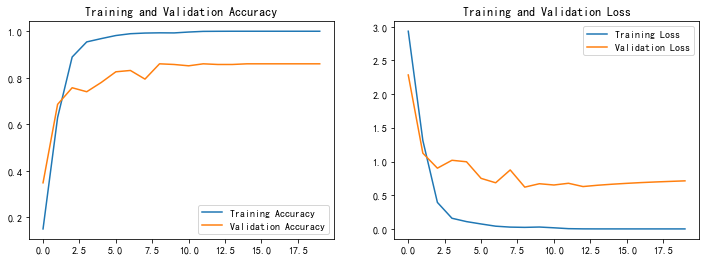

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 7.保存和加载模型

In [40]:
# 保存模型
model.save('model/12_model.h5')

In [41]:
# 加载模型
new_model = tf.keras.models.load_model('model/12_model.h5')

## 8.预测

可以看到验证码中大部分字符预测都是对的，但是少部分字符还是存在问题，大家可以试试优化一下网络结构，调整网络参数等。本案例适合练习优化技巧，借着这个案例了解一下不同的调整对结果有什么不同。

1/1 [==============================] - 0s 26ms/step


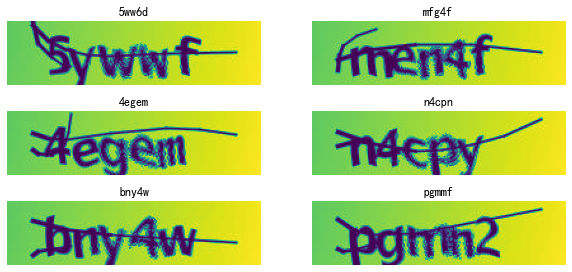

In [42]:
def vec2text(vec):
    """
    还原标签（向量->字符串）
    """
    text = []
    for i, c in enumerate(vec):
        text.append(char_set[c])
    return "".join(text)

plt.figure(figsize=(10, 8))            # 图形的宽为10高为8

for images, labels in val_ds.take(1):
    for i in range(6):
        ax = plt.subplot(5, 2, i + 1)  
        # 显示图片
        plt.imshow(images[i])

        # 需要给图片增加一个维度
        img_array = tf.expand_dims(images[i], 0) 

        # 使用模型预测验证码
        predictions = model.predict(img_array)
        plt.title(vec2text(np.argmax(predictions, axis=2)[0]))

        plt.axis("off")